In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# from scipy.sparse.linalg import LinearOperator, cg, lsqr

# import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *



In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
dr_xyz = 4*dx

grid_rx_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)
grid_ry_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

In [5]:
# Microseismic sources
sx, sy, sz = [nx//3, 2*ny//3, 3*nz//4]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

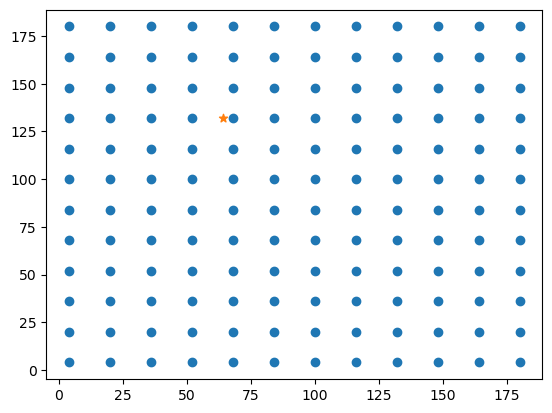

In [6]:
plt.scatter(recs[0],recs[1])
plt.scatter(sx*dx,sy*dy, marker='*')

# MAKE DATA

In [7]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [8]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-1105.2615334883053 - u^H(Op^Hv)=-1105.2615334883012


Text(0.5, 1.0, 'Point Receivers')

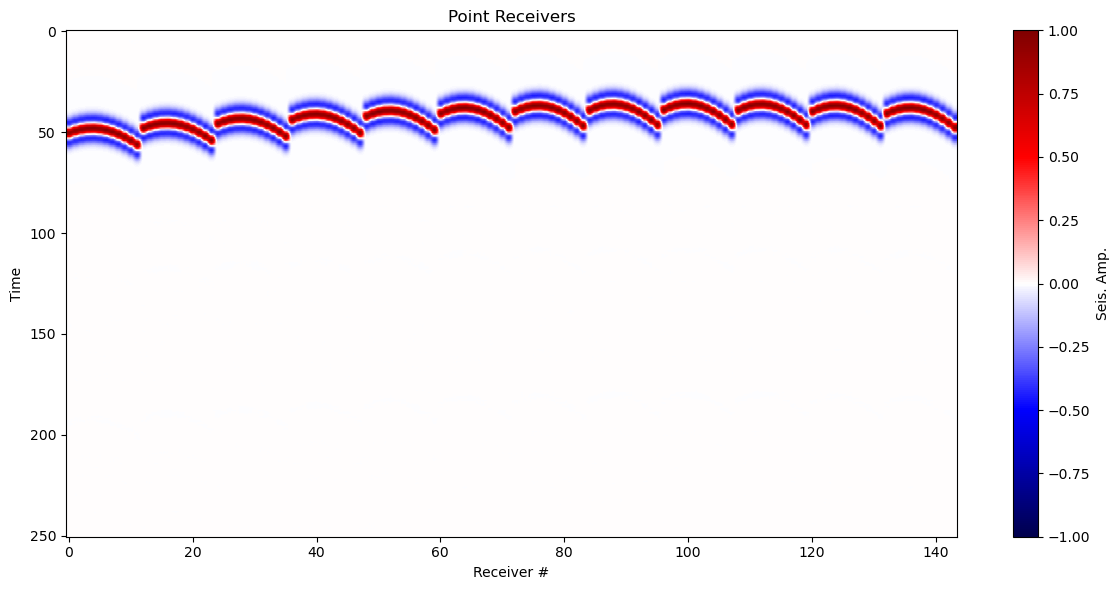

In [9]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

# SOLUTION OPTIONS

In [16]:
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

In [18]:
XC_inv, xci_hc, dls_torch, losshist = xcorr_imaging(Op, 
                                                    frwddata, 
                                                    [nx,ny,nz], 
                                                    niter=100, 
                                                    xceps=8e-1, 
                                                    lr=1e-5, 
                                                    nforhc=10, 
                                                    verbose=True)

Iteration 0, Loss: 2.89744
Iteration 10, Loss: 0.48725
Iteration 20, Loss: -0.00826
Iteration 30, Loss: -0.34156
Iteration 40, Loss: -0.44240
Iteration 50, Loss: -0.58197
Iteration 60, Loss: -0.61811
Iteration 70, Loss: -0.68389
Iteration 80, Loss: -0.69957
Iteration 90, Loss: -0.73172


In [11]:
migrated, mig_hc = migration(Op, frwddata, [nx,ny,nz], nforhc=10)
inv, inv_hc = lsqr_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False)
fista, fista_hc = fista_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False)

In [12]:
print('Migration Hypo-Centers:', mig_hc)
print('LSQR Inversion Hypo-Centers:', inv_hc)
print('FISTA Inversion Hypo-Centers:', fista_hc)

Migration Hypo-Centers: [16.2 33.  37. ]
LSQR Inversion Hypo-Centers: [16.2 33.  37. ]
FISTA Inversion Hypo-Centers: [16.2 33.  37. ]


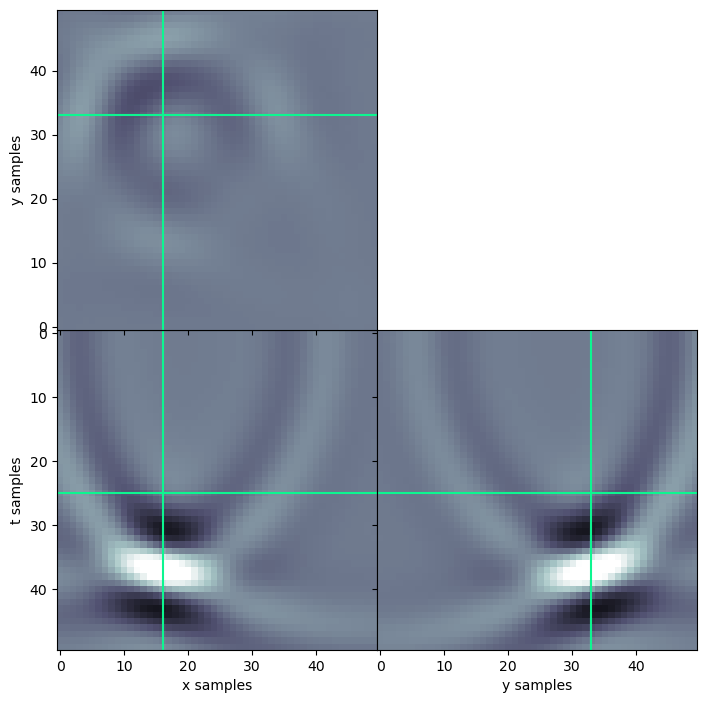

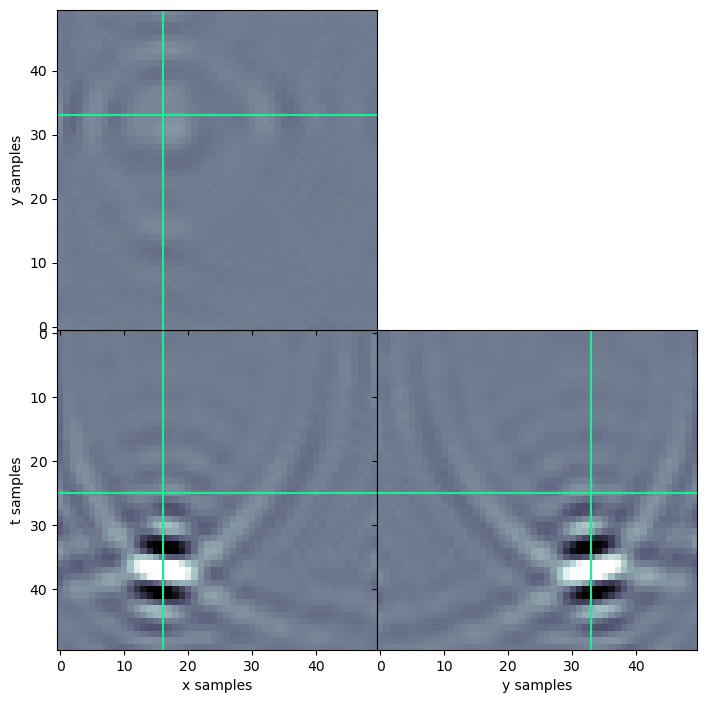

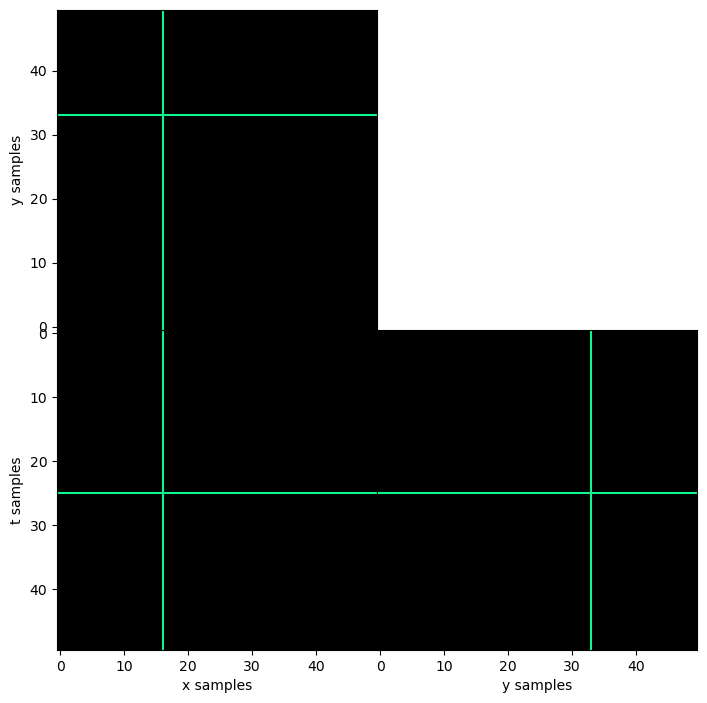

In [13]:
fig,axs = locimage3d(migrated, x0=sx, y0=sy)
fig,axs = locimage3d(inv, x0=sx, y0=sy)
fig,axs = locimage3d(fista, x0=sx, y0=sy)